##Install Dependencies
Let's install PyTorch and fastai libraries first. You have to repeat this step every time you restart this notebook in colab.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x635d2000 @  0x7efe5d6042a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 153kB 6.2MB/s 
    100% |████████████████████████████████| 1.9MB 14.2MB/s 
    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x609d6000 @  0x7fd9d75fa2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

## Import Dataset

In [0]:
#import dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

##Create Dataframe
This provides the Label/Target and the associated text

In [0]:
# create a dataframe
df = pd.DataFrame({'label':dataset.target,
                   'text':dataset.data})

In [0]:
df.shape

(11314, 2)

In [0]:
df.head()

,label,text
0,17,Well i'm not sure about the story nad it did s...
1,0,"\n\n\n\n\n\n\nYeah, do you expect people to re..."
2,17,Although I realize that principle is not one o...
3,11,Notwithstanding all the legitimate fuss about ...
4,10,"Well, I will have to change the scoring on my ..."


In [0]:
df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

In [0]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

## Preprocessing

Tokenization

Remove StopWords

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') 

In [0]:
# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df['text'] = detokenized_doc

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [0]:
df_trn.shape, df_val.shape

((710, 2), (474, 2))

## Data Preparation

### Language model data
for learning the Language semantics

### Classifier model data
for learning the classification Task on text data

**text.learner contains helper functions to quickly create a language model or an RNN classifier**


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

This does all the necessary preprocessing behing the scene. For the classifier, we also pass the vocabulary (mapping from ids to words) that we want to use: this is to ensure that data_clas will use the same dictionary as data_lm.



In [0]:
#Fine-tuning a language model
#We can use the data_lm object we created earlier to fine-tune a pretrained language model.
#fast.ai has an English model available that we can download. 
#We can create a learner object that will directly create a model, 
#download the pretrained weights and be ready for fine-tuning.
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)

In [0]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,7.808674,6.311074,0.129677


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


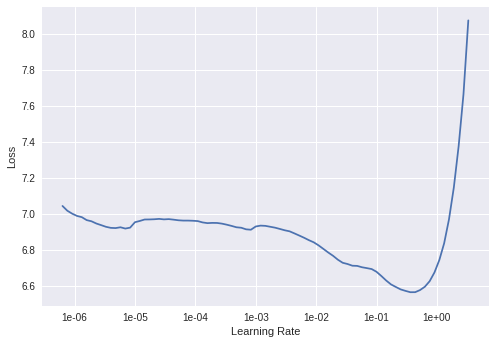

In [0]:
learn.recorder.plot()

In [0]:
learn.save_encoder('ft_enc')
#Finally we save the encoder to be able to use it for classification in the next section.

##Building a classifier
We now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder. The learner object can be done in a single line.



In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.7)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


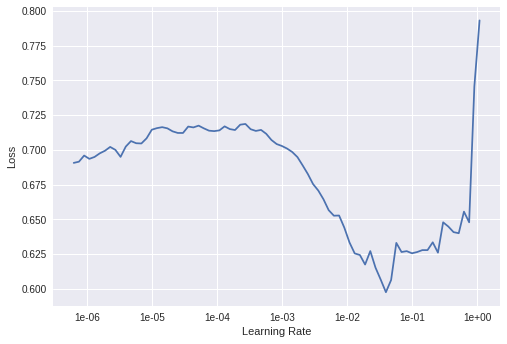

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.526815,0.417662,0.835443


In [0]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,172,16
1,62,224


In [0]:
print("Process completed ")

Process completed 
